# 练习cifar10

In [ ]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os,sys
import pandas as pd
import sklearn
import tensorflow as tf
from tensorflow import keras
from keras import layers

In [ ]:
import json
os.chdir('/content/drive/MyDrive/Colab Notebooks')
!mkdir -p ~/.kaggle
!cp ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle config set -n path -v /content/

- path is now set to: /content/


In [ ]:
%cd /content

/content


In [ ]:
!kaggle competitions download -c cifar-10

 96% 689M/715M [00:07<00:00, 87.1MB/s]
100% 715M/715M [00:07<00:00, 95.0MB/s]


In [ ]:
!ls /content/competitions/cifar-10

cifar-10.zip


In [ ]:
!unzip /content/competitions/cifar-10/cifar-10.zip

Archive:  /content/competitions/cifar-10/cifar-10.zip
  inflating: sampleSubmission.csv    
  inflating: test.7z                 
  inflating: train.7z                
  inflating: trainLabels.csv         


In [ ]:
!ls /content

competitions  sample_data	    test.7z   trainLabels.csv
drive	      sampleSubmission.csv  train.7z


In [ ]:
!apt-get install p7zip-full

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
The following package was automatically installed and is no longer required:
  libnvidia-common-460
Use 'apt autoremove' to remove it.
0 upgraded, 0 newly installed, 0 to remove and 49 not upgraded.


In [ ]:
!7z x /content/test.7z

Output hidden; open in https://colab.research.google.com to view.

In [68]:
!7z x /content/train.7z


7-Zip [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan /content/                   1 file, 109723070 bytes (105 MiB)

Extracting archive: /content/train.7z
--
Path = /content/train.7z
Type = 7z
Physical Size = 109723070
Headers Size = 294768
Method = LZMA:26
Solid = +
Blocks = 1

  0%      2% - train/1.png                    2% 1051 - train/10944.png                             2% 1546 - train/1139.png                            4% 1868 - train/1168.png                            6% 1888 - train/11698.png                           

In [69]:
class_names = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

In [70]:
train_labels_file = 'trainLabels.csv'
test_csv_file = 'sampleSubmission.csv'
train_folder = 'train'
test_folder = 'test'

In [71]:
def parse_csv_file(file_path,folder):
  """解析csv文件"""
  results = []
  with open(file_path, 'r') as f:
    lines = f.readlines()[1:] # 读取数据的时候跳过第一行
  for line in lines:
    image_id, label_str = line.strip('\n').split(',')
    image_full_path = os.path.join(folder,image_id + '.png')
    results.append((image_full_path,label_str))
  return results

# 解析对应的文件夹
train_labels_info = parse_csv_file(train_labels_file,train_folder)
test_csv_info = parse_csv_file(test_csv_file,test_folder)
import pprint
pprint.pprint(train_labels_info[0:3])
pprint.pprint(test_csv_info[0:3])
print(len(train_labels_info), len(test_csv_info))

[('train/1.png', 'frog'), ('train/2.png', 'truck'), ('train/3.png', 'truck')]
[('test/1.png', 'cat'), ('test/2.png', 'cat'), ('test/3.png', 'cat')]
50000 300000


In [72]:
# 划分验证集
train_df = pd.DataFrame(train_labels_info[0:45000])
val_df = pd.DataFrame(train_labels_info[45000:])
test_df = pd.DataFrame(test_csv_info)
# 给数据集赋上索引名
train_df.columns = ['filepath','class']
val_df.columns = ['filepath','class']
test_df.columns = ['filepath','class']
print(train_df.head())
print(val_df.head())
print(test_df.head())

      filepath       class
0  train/1.png        frog
1  train/2.png       truck
2  train/3.png       truck
3  train/4.png        deer
4  train/5.png  automobile
          filepath       class
0  train/45001.png       horse
1  train/45002.png  automobile
2  train/45003.png        deer
3  train/45004.png  automobile
4  train/45005.png    airplane
     filepath class
0  test/1.png   cat
1  test/2.png   cat
2  test/3.png   cat
3  test/4.png   cat
4  test/5.png   cat


In [76]:
print(train_df.shape)

(45000, 2)


In [62]:
!pwd

/content


In [77]:
height,width = 32,32
channels,batch_size = 3, 32
num_classes = 10
# 进行数据增强
train_datagen = keras.preprocessing.image.ImageDataGenerator(
    rescale = 1./255,
    rotation_range = 40,
    width_shift_range = 0.2,
    shear_range = 0.2,
    zoom_range = 0.2,
    horizontal_flip = True, 
    vertical_flip=True,)
train_generator = train_datagen.flow_from_dataframe(train_df,
                                                    directory='./',
                                                    x_col = 'filepath',
                                                    y_col = 'class',
                                                    classes = class_names,
                                                    target_size = (height,width),
                                                    batch_size = batch_size,
                                                    seed = 8,
                                                    shuffle = True,
                                                    class_mode = 'sparse')


Found 45000 validated image filenames belonging to 10 classes.


In [78]:
val_datagen = keras.preprocessing.image.ImageDataGenerator(rescale = 1./255)
val_generator = val_datagen.flow_from_dataframe(val_df,
                                                directory='./',
                                                y_col = 'class',
                                                x_col = 'filepath',
                                                classes = class_names,
                                                target_size = (height,width),
                                                batch_size = batch_size,
                                                seed = 8,
                                                shuffle = True,
                                                class_mode = 'sparse')

Found 5000 validated image filenames belonging to 10 classes.


In [79]:
train_num = train_generator.samples
val_num = val_generator.samples
print(train_num,val_num)

45000 5000


In [74]:
!ls test|wc -l

300000


In [75]:
!ls train|wc -l

50000


In [81]:
for i in range(2):
  x, y = train_generator.next()
  print(x.shape, y.shape)
  print(y)

(32, 32, 32, 3) (32,)
[5. 7. 4. 7. 1. 2. 5. 4. 1. 7. 4. 4. 1. 6. 8. 1. 4. 1. 7. 3. 1. 9. 0. 7.
 3. 3. 7. 9. 1. 3. 5. 0.]
(32, 32, 32, 3) (32,)
[3. 2. 8. 1. 5. 8. 0. 8. 9. 4. 0. 5. 4. 0. 6. 6. 6. 6. 2. 4. 8. 0. 8. 5.
 4. 4. 1. 6. 7. 8. 6. 2.]


In [82]:
# 搭建模型
model = keras.models.Sequential([
    keras.layers.Conv2D(128, (3,3), padding='same',activation='selu', 
                        input_shape=[width, height, channels]),
    keras.layers.BatchNormalization(),#为了是模型训练的更快
    keras.layers.Conv2D(128,(3,3), padding='same',
                        activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),
    
    keras.layers.Conv2D(256,(3,3), padding='same',activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(256,(3,3), padding='same',activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Conv2D(512,(3,3), padding='same',activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.Conv2D(512,(3,3), padding='same',activation='selu'),
    keras.layers.BatchNormalization(),
    keras.layers.MaxPool2D(pool_size=2),

    keras.layers.Flatten(),
    keras.layers.Dense(512, activation='selu'),
    keras.layers.Dense(num_classes, activation='softmax'),
])

model.compile(loss="sparse_categorical_crossentropy",
              optimizer="adam", metrics=['accuracy'])

In [84]:
epochs = 20
history = model.fit(train_generator,
                    steps_per_epoch = train_num // batch_size,
                    epochs = epochs,
                    validation_data = val_generator,
                    validation_steps = val_num // batch_size)

Epoch 1/20
1406/1406 [==============================] - 61s 35ms/step - loss: 2.4475 - accuracy: 0.2804 - val_loss: 1.9855 - val_accuracy: 0.3341
Epoch 2/20
1406/1406 [==============================] - 47s 33ms/step - loss: 1.7157 - accuracy: 0.3805 - val_loss: 1.4922 - val_accuracy: 0.4679
Epoch 3/20
1406/1406 [==============================] - 56s 40ms/step - loss: 1.5686 - accuracy: 0.4396 - val_loss: 1.8356 - val_accuracy: 0.4561
Epoch 4/20
1406/1406 [==============================] - 52s 37ms/step - loss: 1.4287 - accuracy: 0.4946 - val_loss: 1.3155 - val_accuracy: 0.5537
Epoch 5/20
1406/1406 [==============================] - 48s 34ms/step - loss: 1.3035 - accuracy: 0.5432 - val_loss: 1.2303 - val_accuracy: 0.5745
Epoch 6/20
1406/1406 [==============================] - 56s 40ms/step - loss: 1.1883 - accuracy: 0.5866 - val_loss: 1.5762 - val_accuracy: 0.5579
Epoch 7/20
1406/1406 [==============================] - 51s 36ms/step - loss: 1.1109 - accuracy: 0.6140 - val_loss: 1.0343 -

{'loss': [2.447483777999878, 1.715699553489685, 1.5685737133026123, 1.4286723136901855, 1.3035271167755127, 1.188281536102295, 1.1108646392822266, 1.0405280590057373, 0.990689218044281, 0.9262617230415344, 0.8878337740898132, 0.8448374271392822, 0.8079174757003784, 0.7884036898612976, 0.7619721293449402, 0.7367450594902039, 0.7116085290908813, 0.7014767527580261, 0.6696557402610779, 0.6551013588905334], 'accuracy': [0.28035491704940796, 0.3805372714996338, 0.4396459758281708, 0.4945961534976959, 0.5431640148162842, 0.5865949392318726, 0.6139699220657349, 0.6397882699966431, 0.6593800187110901, 0.6841531991958618, 0.6983410716056824, 0.7129958868026733, 0.7253825068473816, 0.736768364906311, 0.7423945665359497, 0.7507116198539734, 0.760118305683136, 0.7629870176315308, 0.7754403352737427, 0.7796655297279358], 'val_loss': [1.9855440855026245, 1.4922198057174683, 1.8356359004974365, 1.3155231475830078, 1.230331540107727, 1.5761858224868774, 1.0342779159545898, 1.12056303024292, 1.24018251

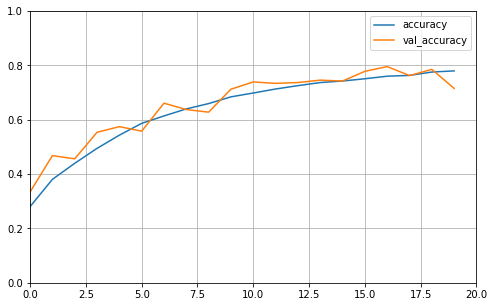

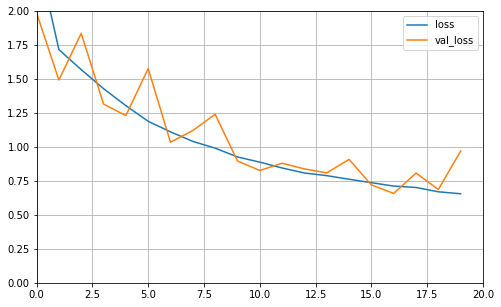

In [85]:
print(history.history)
def plot_learning_curves(history, label, epcohs, min_value, max_value):
    data = {}
    data[label] = history.history[label]
    data['val_'+label] = history.history['val_'+label]
    pd.DataFrame(data).plot(figsize=(8, 5))
    plt.grid(True)
    plt.axis([0, epochs, min_value, max_value])
    plt.show()
    
plot_learning_curves(history, 'accuracy', epochs, 0, 1)
plot_learning_curves(history, 'loss', epochs, 0, 2)

In [86]:
test_datagen = keras.preprocessing.image.ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_dataframe(test_df,
                                                directory='./',
                                                y_col = 'class',
                                                x_col = 'filepath',
                                                classes = class_names,
                                                target_size = (height,width),
                                                batch_size = batch_size,
                                                seed = 8,
                                                shuffle = True,
                                                class_mode = 'sparse')
test_num = test_generator.samples
print(test_num)

Found 300000 validated image filenames belonging to 10 classes.
300000


In [87]:
#利用训练好的模型进行预测
test_predict = model.predict(test_generator,workers=2,use_multiprocessing=True)
test_predict_class_indices = np.argmax(test_predict,axis=1)
test_predict_class = [class_names[index] for index in test_predict_class_indices]

In [88]:
print(test_predict.shape)
print(test_predict[0])

(300000, 10)
[0.15809284 0.01326679 0.30859506 0.0213606  0.08820038 0.00291236
 0.33578354 0.00345953 0.0606767  0.00765224]


In [89]:
# 生成报告
def generate_submissions(filename, predict_class):
  with open(filename, 'w') as f:
    f.write('id,label\n')
    for i in range(len(predict_class)):
      f.write('%d,%s\n' % (i+1, predict_class[i]))

output_file = "./submission.csv"
generate_submissions(output_file, test_predict_class)

In [ ]:
!cp -r /content/test /content/drive/MyDrive/datasets/competitions/

In [ ]:
!cp -r /content/train /content/drive/MyDrive/datasets/competitions/